In [7]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tfs
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import seaborn as sns

In [8]:
df = pd.read_csv('GOOG.csv')

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-07-11,7.382329,7.387311,7.248331,7.306364,7.306364,336869956
1,2005-07-12,7.307360,7.332516,7.246090,7.267261,7.267261,235475323
2,2005-07-13,7.285442,7.453064,7.275231,7.443600,7.443600,459230882
3,2005-07-14,7.604995,7.640113,7.473737,7.494160,7.494160,428307406
4,2005-07-15,7.502877,7.556676,7.466514,7.501632,7.501632,338801168


In [10]:
df = df[['Date', 'Close']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4197 entries, 0 to 4196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4197 non-null   object 
 1   Close   4197 non-null   float64
dtypes: float64(1), object(1)
memory usage: 65.7+ KB


In [12]:
df['Date'].min(), df['Date'].max()

('2005-07-11', '2022-03-10')

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2005-2022')
fig.show()

In [14]:
train = df.loc[df['Date'] <= '2017-12-24']
test = df.loc[df['Date'] > '2017-12-24']
train.shape, test.shape

((3138, 2), (1059, 2))

In [15]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

C:\Users\arund\anaconda3\envs\anomalydetection\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arund\anaconda3\envs\anomalydetection\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



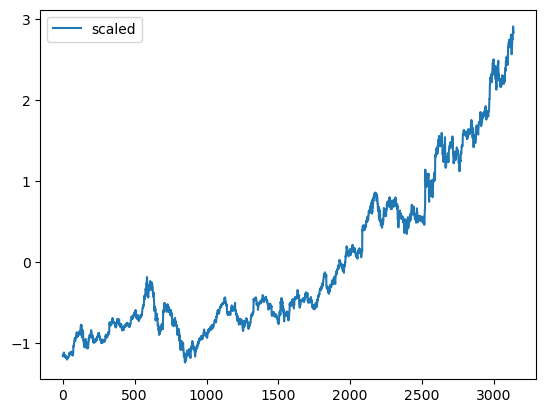

In [16]:
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [17]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3108, 30, 1)
Testing input shape:  (1029, 30, 1)


In [18]:
X_train[3107]

array([[2.70524881],
       [2.69133225],
       [2.68121095],
       [2.68230167],
       [2.66009652],
       [2.71065838],
       [2.65215632],
       [2.64905899],
       [2.71933978],
       [2.72575282],
       [2.74603862],
       [2.80536939],
       [2.77570401],
       [2.66336826],
       [2.66227754],
       [2.6132424 ],
       [2.56311654],
       [2.59134246],
       [2.64905899],
       [2.70380925],
       [2.7305081 ],
       [2.74817636],
       [2.74547141],
       [2.74603862],
       [2.78329495],
       [2.84890771],
       [2.90540273],
       [2.87722079],
       [2.85222343],
       [2.84646468]])

In [19]:
np.random.seed(21)
tfs.random.set_seed(21)

In [20]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [21]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
88/88 [==============================] - 10s 55ms/step - loss: 0.0597 - val_loss: 0.0930
Epoch 2/100
88/88 [==============================] - 4s 46ms/step - loss: 0.0264 - val_loss: 0.0602
Epoch 3/100
88/88 [==============================] - 4s 49ms/step - loss: 0.0254 - val_loss: 0.0397
Epoch 4/100
88/88 [==============================] - 4s 50ms/step - loss: 0.0184 - val_loss: 0.0296
Epoch 5/100
88/88 [==============================] - 5s 55ms/step - loss: 0.0196 - val_loss: 0.0287
Epoch 6/100
88/88 [==============================] - 4s 50ms/step - loss: 0.0152 - val_loss: 0.0210
Epoch 7/100
88/88 [==============================] - 4s 50ms/step - loss: 0.0151 - val_loss: 0.0218
Epoch 8/100
88/88 [==============================] - 5s 52ms/step - loss: 0.0134 - val_loss: 0.0238
Epoch 9/100
88/88 [==============================] - 4s 51ms/step - loss: 0.0148 - val_loss: 0.0242
Epoch 10/100
88/88 [==============================] - 5s 54ms/step - loss: 0.0146 - val_loss: 0.027

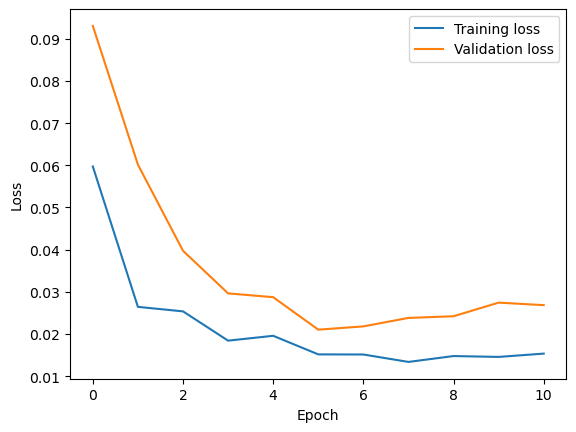

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

98/98 [==============================] - 2s 13ms/step
Reconstruction error threshold: 0.46745738963319333


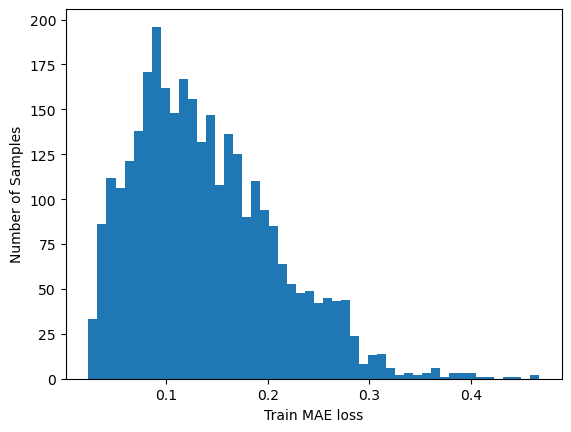

In [23]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

33/33 [==============================] - 0s 12ms/step


Text(0, 0.5, 'Number of samples')

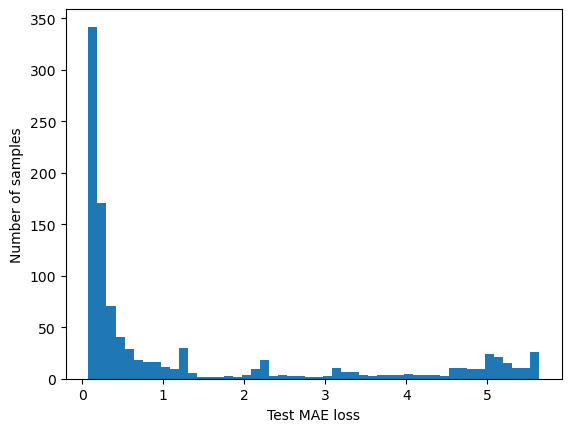

In [24]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [25]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [26]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
3168,2018-02-08,2.575506,0.171077,0.467457,False
3169,2018-02-09,2.733693,0.213813,0.467457,False
3170,2018-02-12,2.795466,0.236541,0.467457,False
3171,2018-02-13,2.796164,0.241020,0.467457,False
3172,2018-02-14,2.872946,0.242525,0.467457,False


In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [28]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
3681,2020-02-25,4.263510,0.489599,0.467457,True
3682,2020-02-26,4.284145,0.549535,0.467457,True
3683,2020-02-27,3.956561,0.589874,0.467457,True
3684,2020-02-28,4.049222,0.659710,0.467457,True
3685,2020-03-02,4.266390,0.697178,0.467457,True


In [29]:
anomalies.shape

(424, 5)

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close'],name='Close price' ))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Close'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [51]:
arr=[1,2,34,5];
i = len(arr);
while(i<5):
   print("a");